In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
from collections import defaultdict

In [2]:
def load_jsonl(file_path: str) -> List[Dict]:
    """Load data from a jsonl file."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [12]:
def get_average_scores(data: List[Dict]) -> Tuple[float, float]:
    """Calculate average COMET and COMET-KIWI scores from data."""
    comet_scores = [
        item.get("comet_score", 0) for item in data if "comet_score" in item
    ]
    kiwi_scores = [
        item.get("comet_kiwi_score", 0) for item in data if "comet_kiwi_score" in item
    ]

    avg_comet = np.mean(comet_scores) if comet_scores else 0
    avg_kiwi = np.mean(kiwi_scores) if kiwi_scores else 0

    return avg_comet, avg_kiwi

In [13]:
# Base directory
base_dir = "/scratch/project_462000941/members/zihao/rm4mt/rm4mt_translated_with_comet"

# Dictionary to store results: task -> model -> budget -> (avg_comet, avg_kiwi)
results = defaultdict(lambda: defaultdict(dict))

In [42]:
# Scan directory structure
for task in os.listdir(base_dir):
    task_dir = os.path.join(base_dir, task)
    if not os.path.isdir(task_dir):
        continue
        
    for model in os.listdir(task_dir):
        model_dir = os.path.join(task_dir, model)
        if not os.path.isdir(model_dir):
            continue
            
        for budget_folder in os.listdir(model_dir):
            budget_dir = os.path.join(model_dir, budget_folder)
            if not os.path.isdir(budget_dir):
                continue
                
            # Extract budget as integer
            try:
                if budget_folder.startswith('budget_'):
                    budget = int(budget_folder.split('_')[1])
                else:
                    budget = int(budget_folder)
            except ValueError:
                print(f"Skipping non-budget folder: {budget_folder}")
                continue
            
            # Look for jsonl files
            for file in os.listdir(budget_dir):
                if file.endswith('.jsonl'):
                    file_path = os.path.join(budget_dir, file)
                    try:
                        data = load_jsonl(file_path)
                        avg_comet, avg_kiwi = get_average_scores(data)
                        results[task][model][budget] = (avg_comet, avg_kiwi)
                        # We're assuming there's only one relevant jsonl file per budget folder
                        break
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

In [43]:
if "Qwen3-0.6B" in results["DRT-Gutenberg"]:
    del results["DRT-Gutenberg"]["Qwen3-0.6B"]
del results["DRT-Gutenberg"]["Qwen3-14B"][1000]
del results["DRT-Gutenberg"]["Qwen3-14B"][1500]
del results["DRT-Gutenberg"]["Qwen3-14B"][2000]

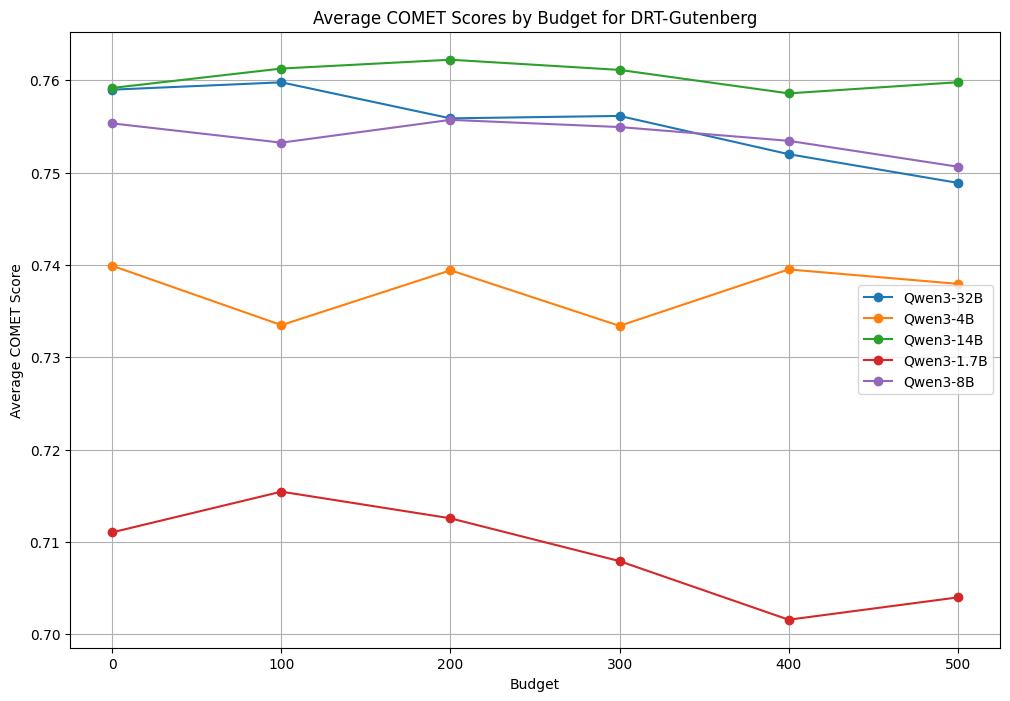

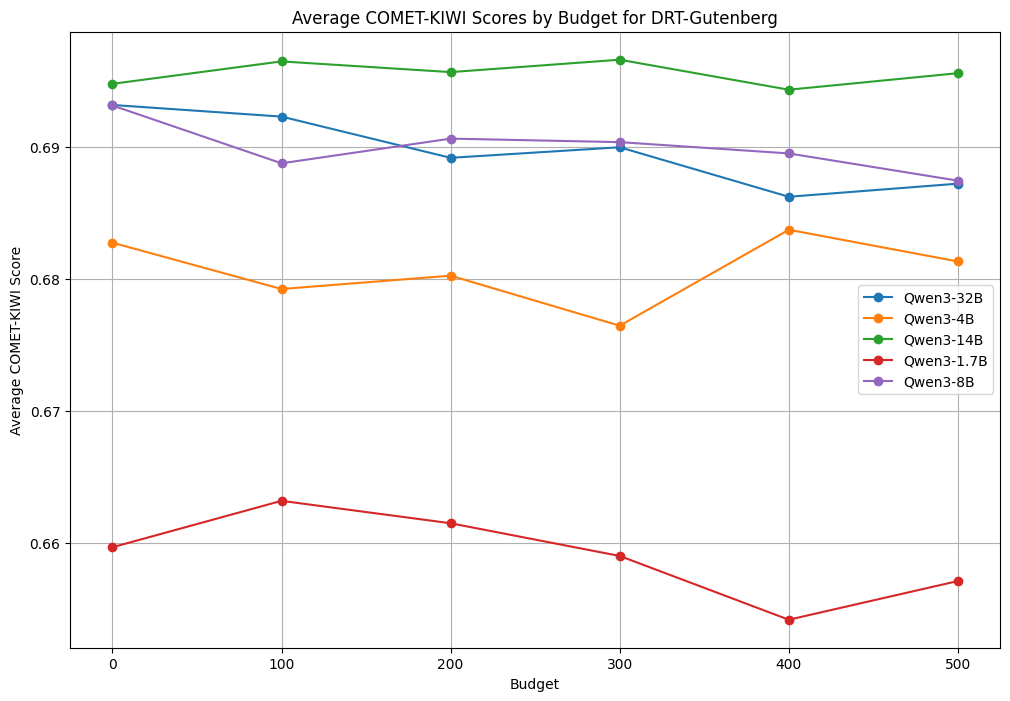

In [44]:
# Create plots for each task
for task, models in results.items():
    # Plot for COMET scores
    plt.figure(figsize=(12, 8))
    for model, budgets in models.items():
        x = sorted(budgets.keys())
        y = [budgets[budget][0] for budget in x]  # COMET scores
        plt.plot(x, y, marker="o", label=model)

    # Set x-axis ticks at intervals of 100
    min_budget = min(
        min(budgets.keys()) for model, budgets in models.items() if budgets
    )
    max_budget = max(
        max(budgets.keys()) for model, budgets in models.items() if budgets
    )
    # Create a range from min to max with step size of 100
    xticks = range(min_budget - min_budget % 100, max_budget + 100, 100)
    plt.xticks(xticks)

    plt.xlabel("Budget")
    plt.ylabel("Average COMET Score")
    plt.title(f"Average COMET Scores by Budget for {task}")
    plt.legend()
    plt.grid(True)

    # Plot for COMET-KIWI scores
    plt.figure(figsize=(12, 8))
    for model, budgets in models.items():
        x = sorted(budgets.keys())
        y = [budgets[budget][1] for budget in x]  # COMET-KIWI scores
        plt.plot(x, y, marker="o", label=model)

    # Set x-axis ticks at intervals of 100
    plt.xticks(xticks)  # Use the same xticks as the previous plot

    plt.xlabel("Budget")
    plt.ylabel("Average COMET-KIWI Score")
    plt.title(f"Average COMET-KIWI Scores by Budget for {task}")
    plt.legend()
    plt.grid(True)

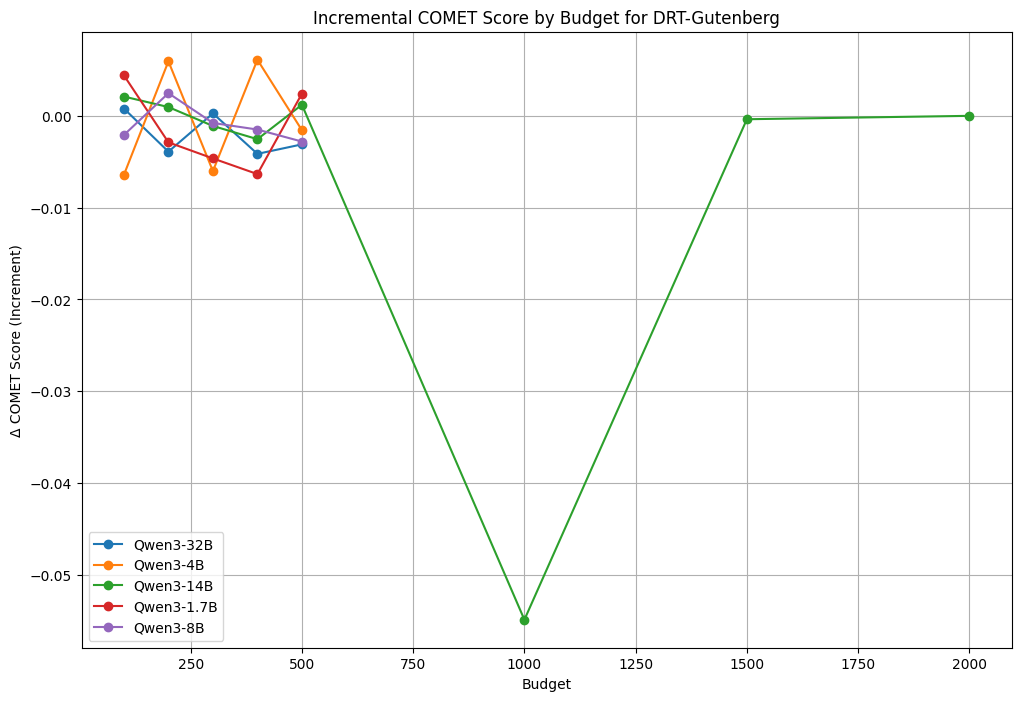

In [33]:
for task, models in results.items():
    plt.figure(figsize=(12, 8))
    for model, budgets in models.items():
        x = sorted(budgets.keys())
        y = [budgets[budget][0] for budget in x]  # COMET scores
        delta_y = [y[i] - y[i - 1] for i in range(1, len(y))]
        plt.plot(x[1:], delta_y, marker="o", label=model)
    plt.xlabel("Budget")
    plt.ylabel("Δ COMET Score (Increment)")
    plt.title(f"Incremental COMET Score by Budget for {task}")
    plt.legend()
    plt.grid(True)

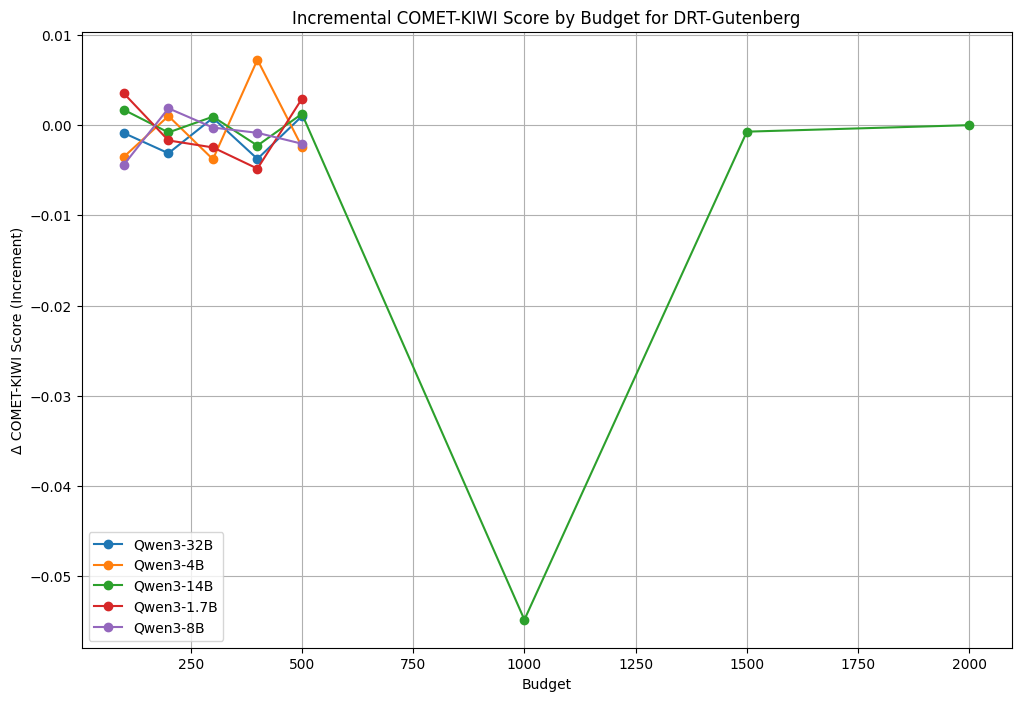

In [34]:
for task, models in results.items():
    plt.figure(figsize=(12, 8))
    for model, budgets in models.items():
        x = sorted(budgets.keys())
        y = [budgets[budget][1] for budget in x]  # COMET-KIWI scores
        delta_y = [y[i] - y[i - 1] for i in range(1, len(y))]
        plt.plot(x[1:], delta_y, marker="o", label=model)
    plt.xlabel("Budget")
    plt.ylabel("Δ COMET-KIWI Score (Increment)")
    plt.title(f"Incremental COMET-KIWI Score by Budget for {task}")
    plt.legend()
    plt.grid(True)